In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('Word_Embedding.csv')

In [4]:
lag_days_range = [1,2,3,4,5,6,7,8,9,10]
lagged_features = []

for lag_day in lag_days_range:
    df[f'Lag_{lag_day}_Perc_Change'] = df['Percentage_Change'].shift(lag_day)
    lagged_features.append(f'Lag_{lag_day}_Perc_Change')


In [7]:
mse_scores_trainset = []
mse_scores_testset = []
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 50] # We choose 10 because previously the best max_depth for all lag_day are 10
}
best_lag_day = None
best_params = None
best_avg_mse = float('inf')

for i in range(1, len(lag_days_range)+1):
    prev_days = lagged_features[:i]
    x = df[prev_days]
    y = df['Percentage_Change']

    x = x.dropna()
    y = y.loc[x.index]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    # 10-fold cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    mse_scores_trainset.append(best_score)

    print(f'{i}-day lagged percentage changes')
    print(f'Best parameters found: {best_params}')
    print(f'Mean Squared Error on train set: {best_score}')

    # Use the best estimator to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(x_test)
    
    # Evaluate the model on the test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_scores_testset.append(mse_test)
    print(f'Mean Squared Error on test set: {mse_test}')
    print() # print empty line
    

1-day lagged percentage changes
Best parameters found: {'max_depth': 10, 'n_estimators': 200}
Mean Squared Error on train set: 13.324610932521148
Mean Squared Error on test set: 12.902323186519977

2-day lagged percentage changes
Best parameters found: {'max_depth': 10, 'n_estimators': 50}
Mean Squared Error on train set: 13.945200789684515
Mean Squared Error on test set: 11.570761906645506

3-day lagged percentage changes
Best parameters found: {'max_depth': 10, 'n_estimators': 200}
Mean Squared Error on train set: 13.867776474450839
Mean Squared Error on test set: 13.236885192831474

4-day lagged percentage changes
Best parameters found: {'max_depth': 10, 'n_estimators': 100}
Mean Squared Error on train set: 13.411979606351768
Mean Squared Error on test set: 13.327128817075465

5-day lagged percentage changes
Best parameters found: {'max_depth': 10, 'n_estimators': 100}
Mean Squared Error on train set: 13.304779752660684
Mean Squared Error on test set: 12.668631637184232

6-day lagge

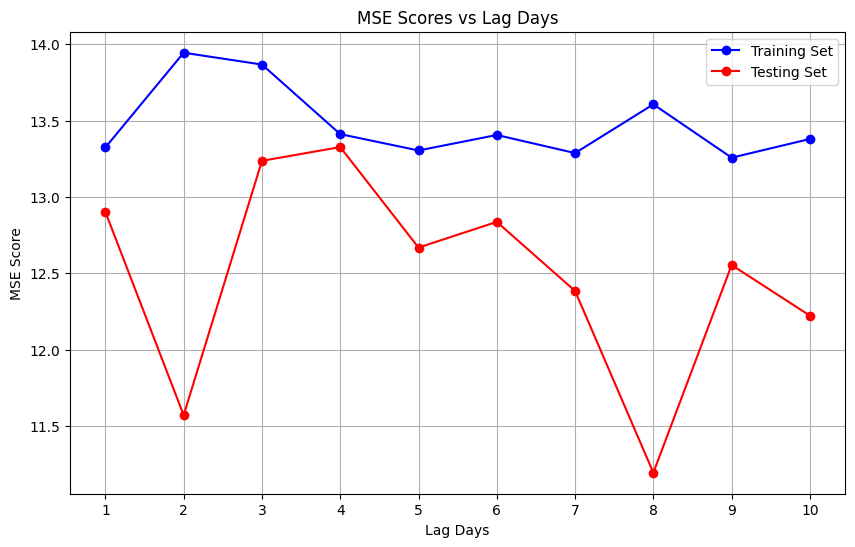

In [8]:
import matplotlib.pyplot as plt

# Plot mse_scores against lag_days_range
plt.figure(figsize=(10, 6))
plt.plot(lag_days_range, mse_scores_trainset, marker='o', color='b', label='Training Set')
plt.plot(lag_days_range, mse_scores_testset, marker='o', color='r', label='Testing Set')
plt.title('MSE Scores vs Lag Days')
plt.xlabel('Lag Days')
plt.ylabel('MSE Score')
plt.xticks(lag_days_range)
plt.grid(True)
plt.legend()
plt.show()

